### Imports

In [13]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import xgboost as xgb
import numpy as np
import inspect
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, precision_recall_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

### Reading Data

In [14]:
data = pickle.load(open("data_preprocessing/preprocessed_hr_data.pkl", "rb"))

In [15]:
data = pd.read_csv("../data/HR.csv")
data = data.rename(columns={"sales": "department"})
print(data.columns)
data = pd.get_dummies(data)
categorical = ['department_IT', 'department_RandD', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium']
data[categorical] = data[categorical].astype(float)
print(data.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')
Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department_IT', 'department_RandD',
       'department_accounting', 'department_hr', 'department_management',
       'department_marketing', 'department_product_mng', 'department_sales',
       'department_support', 'department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')


### Exploring Data

In [16]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.80,0.86,5,262,6,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.11,0.88,7,272,4,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.72,0.87,5,223,5,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.37,0.52,2,159,3,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Splitting Data Into Train and Test Set

In [17]:
y = data['left']
X = data.drop(columns=['left'])

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create training and validation sets (80% train, 20% validation of remaining data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print("Training set size:", X_train.shape[0])
print("Validation test size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 9599
Validation test size: 2400
Test set size: 3000


### Converting Data into Tensors

In [19]:
feature_names = X_train.columns.tolist()
X_train_val = X_train_val.to_numpy()
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()


In [20]:
X_train_val_tensor = torch.tensor(X_train_val, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_val_tensor = torch.tensor(y_train_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### Training the XGBoost Model

In [21]:

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'alpha': 0.1,
    'lambda': 10,
    'subsample': 0.8
}
num_rounds = 100
xgb_model = xgb.XGBClassifier(**params)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_val_tensor, y_train_val_tensor, cv=skf, scoring='roc_auc')
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

Cross-validation AUC scores: [0.98533359 0.99310103 0.99091827 0.98831789 0.99512257]
Mean AUC: 0.9906, Std: 0.0035


In [23]:
train_dmatrix = xgb.DMatrix(X_train_val_tensor, label=y_train_val_tensor, feature_names=feature_names)
test_dmatrix = xgb.DMatrix(X_test_tensor, label=y_test_tensor, feature_names=feature_names)

cv_results = xgb.cv(
    params=params,
    dtrain=train_dmatrix,
    num_boost_round=1000,
    nfold=5,
    stratified=True,
    metrics=['auc', 'logloss'],
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=100
)

[0]	train-auc:0.97554+0.00238	train-logloss:0.47674+0.00046	test-auc:0.97374+0.00480	test-logloss:0.47701+0.00073
[100]	train-auc:0.99610+0.00026	train-logloss:0.05948+0.00179	test-auc:0.99083+0.00327	test-logloss:0.07631+0.00859
[200]	train-auc:0.99887+0.00007	train-logloss:0.03986+0.00094	test-auc:0.99186+0.00260	test-logloss:0.06745+0.00802
[300]	train-auc:0.99962+0.00002	train-logloss:0.02879+0.00066	test-auc:0.99195+0.00244	test-logloss:0.06268+0.00776
[400]	train-auc:0.99986+0.00002	train-logloss:0.02201+0.00070	test-auc:0.99194+0.00237	test-logloss:0.06020+0.00783
[500]	train-auc:0.99994+0.00002	train-logloss:0.01756+0.00056	test-auc:0.99184+0.00239	test-logloss:0.05908+0.00788
[600]	train-auc:0.99997+0.00001	train-logloss:0.01449+0.00045	test-auc:0.99172+0.00225	test-logloss:0.05883+0.00771
[615]	train-auc:0.99997+0.00001	train-logloss:0.01411+0.00044	test-auc:0.99170+0.00229	test-logloss:0.05887+0.00788


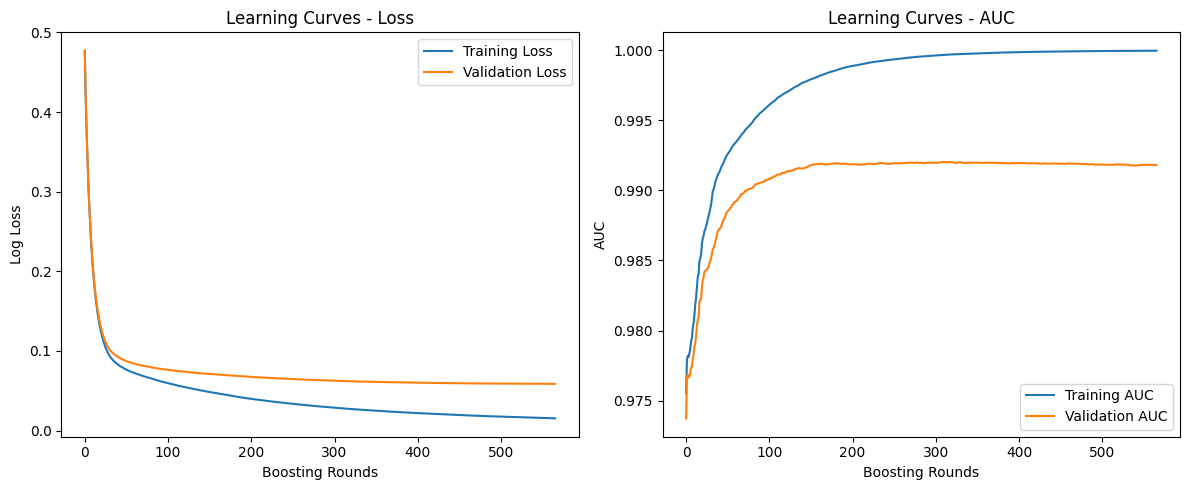

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cv_results['train-logloss-mean'], label='Training Loss')
plt.plot(cv_results['test-logloss-mean'], label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Learning Curves - Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cv_results['train-auc-mean'], label='Training AUC')
plt.plot(cv_results['test-auc-mean'], label='Validation AUC')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.title('Learning Curves - AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
best_rounds = cv_results['test-logloss-mean'].argmin()
print(f"Optimal number of boosting rounds: {best_rounds}")

Optimal number of boosting rounds: 565


In [26]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_rounds,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-logloss:0.47679	validation-logloss:0.47699
[100]	train-logloss:0.06143	validation-logloss:0.07427
[200]	train-logloss:0.04210	validation-logloss:0.06187
[300]	train-logloss:0.03063	validation-logloss:0.05554
[400]	train-logloss:0.02333	validation-logloss:0.05150
[500]	train-logloss:0.01847	validation-logloss:0.04996
[564]	train-logloss:0.01633	validation-logloss:0.04944


### Geting Predictions

In [27]:
preds = xgb_model.predict(dtest)
y_pred = (preds > 0.5).astype(int)

print("\nTest Set Evaluation:")
print(f"AUC: {roc_auc_score(y_test, preds):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Log Loss: {log_loss(y_test, preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Evaluation:
AUC: 0.9938
Accuracy: 0.9853
Log Loss: 0.0550

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.96      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



### Finding the Treshold That Maximizes The f1 Score

In [28]:
threshold = 0
f1_scores = []
while threshold < 1:
    threshold += 0.001
    binary_preds = [1 if p >= threshold else 0 for p in preds]
    f1 = f1_score(y_test, binary_preds)
    f1_scores.append((threshold,f1))

best_treshold = max(f1_scores, key=lambda x: x[1])[0]
best_treshold

0.5950000000000004

### Different Metrics to Measure Model Performance

In [29]:
binary_preds = [1 if p >= best_treshold else 0 for p in preds]

accuracy = accuracy_score(y_test, binary_preds)
precision = precision_score(y_test, binary_preds)
recall = recall_score(y_test, binary_preds)
f1 = f1_score(y_test, binary_preds)
conf_matrix = confusion_matrix(y_test, binary_preds)
logloss = log_loss(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Log Loss: {logloss:.4f}")

print()

print("Precision of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1]))
print("Precision of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))

print("Recall of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[1][0]))
print("Recall of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1]))

recal_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
precision_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])

print("F1 Score of stayed (0): ", 2*conf_matrix[0][0]/(2*conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]))
print("F1 Score of left (1): ", 2*recal_left*precision_left/(recal_left+precision_left))

Accuracy: 0.9870
Precision: 0.9870
Recall: 0.9580
F1 Score: 0.9723
Confusion Matrix: 
[[2277    9]
 [  30  684]]
Log Loss: 0.0550

Precision of stayed (0):  0.9960629921259843
Precision of left (1):  0.957983193277311
Recall of stayed (0):  0.9869960988296489
Recall of left (1):  0.987012987012987
F1 Score of stayed (0):  0.991508817766166
F1 Score of left (1):  0.9722814498933903


### Precision and Recall Curve

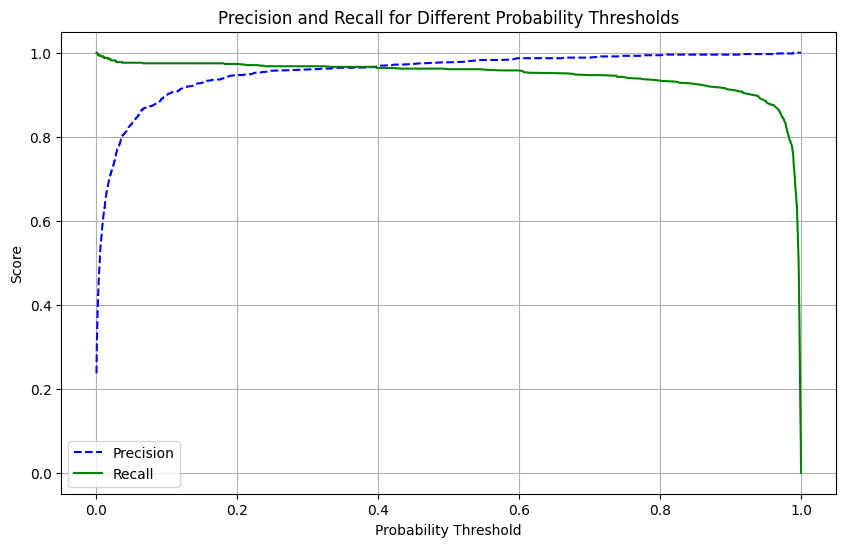

In [30]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, preds)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_curve[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall_curve[:-1], 'g-', label='Recall')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall for Different Probability Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### Probability Distribution by Class

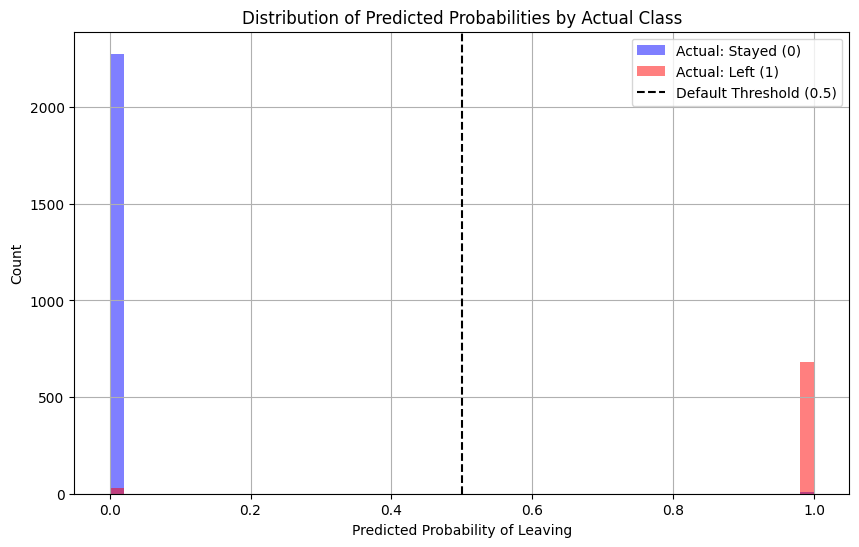

In [31]:
plt.figure(figsize=(10, 6))

prob_class_0 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i].item() == 0]
prob_class_1 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i].item() == 1]

plt.hist(prob_class_0, bins=50, alpha=0.5, label='Actual: Stayed (0)', color='blue')
plt.hist(prob_class_1, bins=50, alpha=0.5, label='Actual: Left (1)', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance Analysis

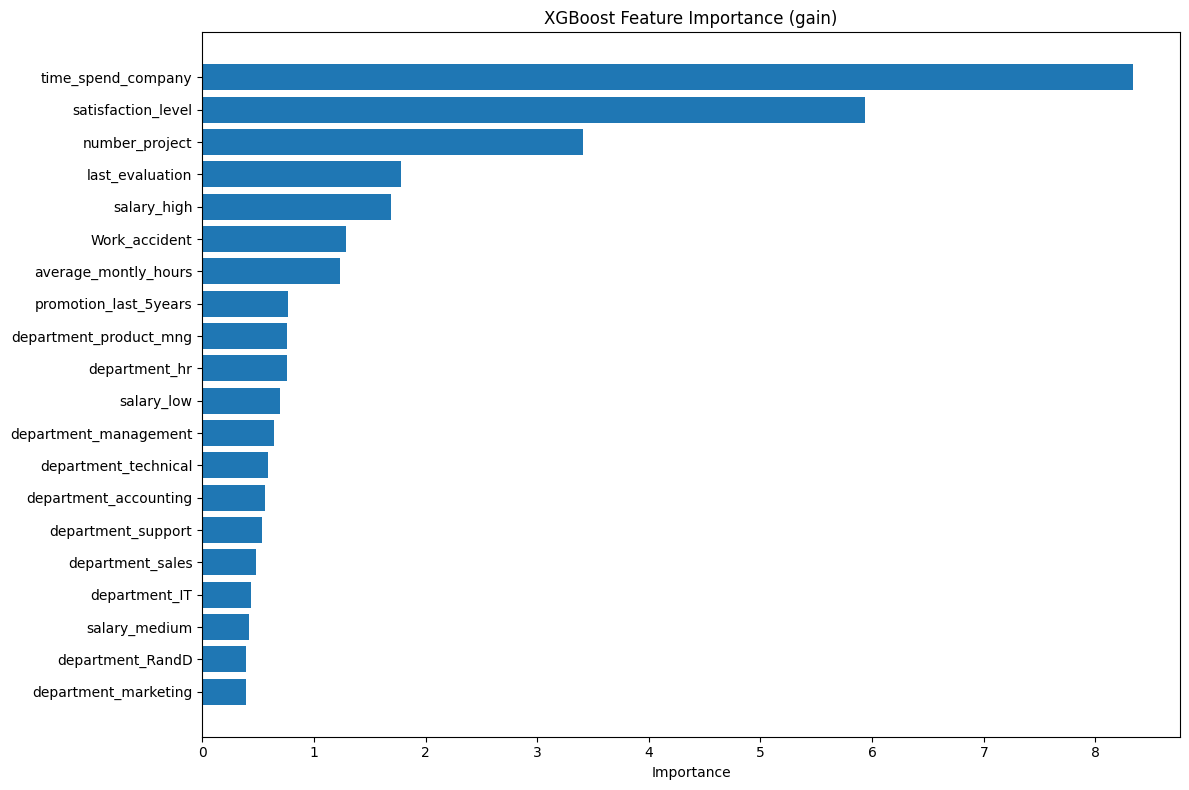


Feature Importance (weight):
                 Feature  Importance (weight)
3   average_montly_hours               3559.0
0     satisfaction_level               3274.0
1        last_evaluation               3029.0
2         number_project               1302.0
4     time_spend_company               1116.0
16  department_technical                333.0
18            salary_low                271.0
14      department_sales                241.0
15    department_support                219.0
19         salary_medium                217.0

Feature Importance (cover):
                   Feature  Importance (cover)
17             salary_high           84.250916
6    promotion_last_5years           74.209923
13  department_product_mng           64.352631
5            Work_accident           59.528599
4       time_spend_company           51.215893
11   department_management           46.137794
2           number_project           42.799500
0       satisfaction_level           41.809341
10          

In [32]:

importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (gain)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

for imp_type in ['weight', 'cover', 'total_gain', 'total_cover']:
    try:
        importance = xgb_model.get_score(importance_type=imp_type)
        importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', f'Importance ({imp_type})'])
        importance_df = importance_df.sort_values(f'Importance ({imp_type})', ascending=False)
        print(f"\nFeature Importance ({imp_type}):")
        print(importance_df.head(10))  
    except:
        print(f"Importance type '{imp_type}' not available")

### Save The Trained Model

In [33]:
#model_path = "xgboost_hr_attrition_model.json"
#xgb_model.save_model(model_path)

c:\Users\Fernando\pccube_workshop\employee-retention-predictive-model\pccube\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Summary of How Features Affect Attrition:
                   Feature       Effect Direction  Importance  Correlation
0       satisfaction_level  ↓ Decreases attrition    2.284613    -0.657454
4       time_spend_company  ↑ Increases attrition    1.038031     0.455667
2           number_project     Minimal/Non-linear    0.946328    -0.074793
3     average_montly_hours  ↑ Increases attrition    0.897086     0.335214
1          last_evaluation  ↑ Increases attrition    0.723187     0.280383
18              salary_low  ↑ Increases attrition    0.281387     0.944614
5            Work_accident  ↓ Decreases attrition    0.209072    -0.963880
16    department_technical  ↑ Increases attrition    0.168011     0.726045
14        department_sales  ↑ Increases attrition    0.143383     0.828957
17             salary_high  ↓ Decreases attrition    0.140991    -0.973433
19           salary_medium  ↑ Increases attrition    0.130206     0.843244
15      department_support  ↑ Increases attrition    0.09

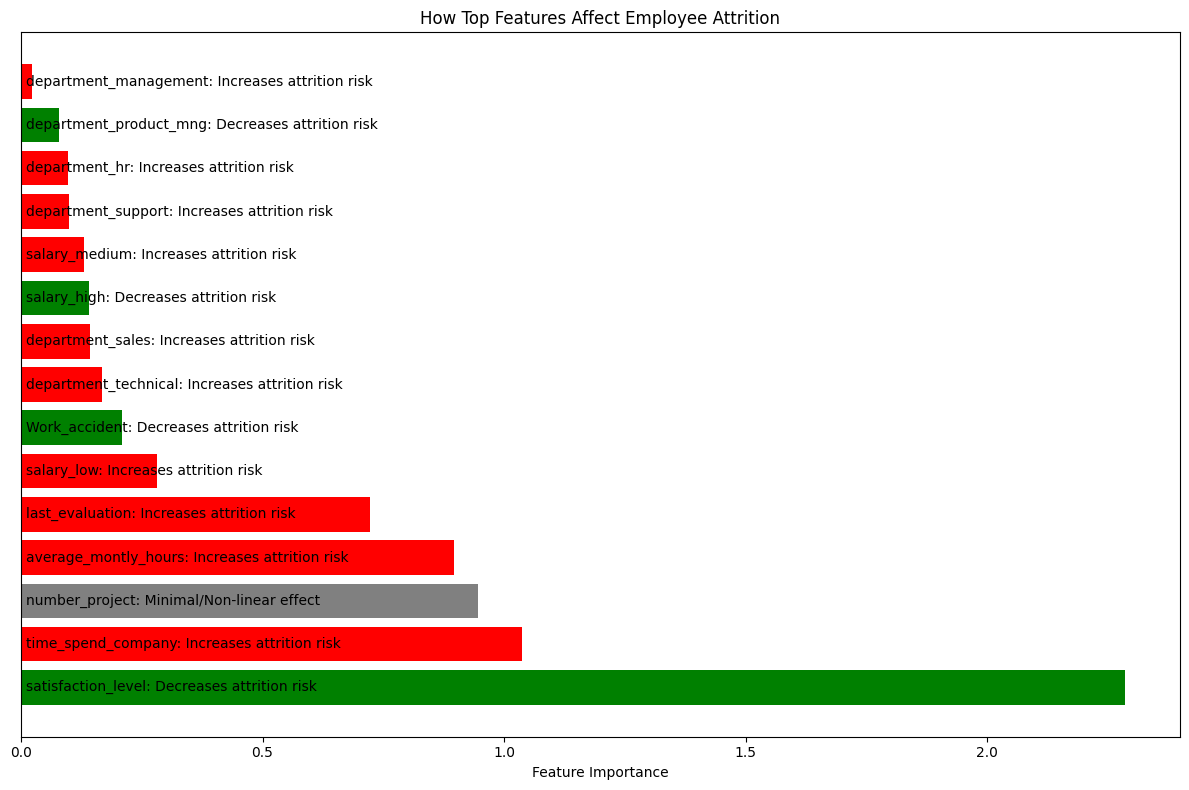

In [34]:
### Summary Table of Feature Effects
import shap

# Create explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for test set (or a sample if it's large)
sample_size = min(500, X_test_tensor.shape[0])  # Limit sample size for speed
X_sample = X_test_tensor[:sample_size].numpy()
X_sample_dmatrix = xgb.DMatrix(X_sample, feature_names=feature_names)
shap_values = explainer.shap_values(X_sample_dmatrix)

# Calculate average effect direction for each feature
feature_effects = []

for i, feature in enumerate(feature_names):
    # Calculate correlation between feature and SHAP value
    if i < shap_values.shape[1]:  # Make sure feature index is valid
        feature_values = X_sample[:, i]
        shap_impact = shap_values[:, i]
        correlation = np.corrcoef(feature_values, shap_impact)[0, 1]
        
        # Determine effect direction
        if abs(correlation) < 0.1:
            effect = "Minimal/Non-linear"
        elif correlation > 0:
            effect = "↑ Increases attrition"
        else:
            effect = "↓ Decreases attrition"
        
        # Calculate average absolute SHAP value (importance)
        importance = np.mean(np.abs(shap_impact))
        
        feature_effects.append({
            'Feature': feature,
            'Effect Direction': effect,
            'Importance': importance,
            'Correlation': correlation
        })

# Create DataFrame and sort by importance
effect_df = pd.DataFrame(feature_effects)
effect_df = effect_df.sort_values('Importance', ascending=False)

# Display the table
print("\nSummary of How Features Affect Attrition:")
print(effect_df.head(15))  # Show top 15 features

# Create a more visual summary for key features
plt.figure(figsize=(12, 8))
top_features = effect_df.head(15)['Feature'].tolist()

for i, feature in enumerate(top_features):
    idx = feature_names.index(feature)
    corr = effect_df[effect_df['Feature'] == feature]['Correlation'].values[0]
    
    # Determine color based on correlation
    if abs(corr) < 0.1:
        color = 'gray'
        effect = "Minimal/Non-linear effect"
    elif corr > 0:
        color = 'red'
        effect = "Increases attrition risk"
    else:
        color = 'green'
        effect = "Decreases attrition risk"
    
    plt.barh(i, effect_df[effect_df['Feature'] == feature]['Importance'].values[0], color=color)
    plt.text(0.01, i, f"{feature}: {effect}", va='center')

plt.yticks([]) 
plt.xlabel('Feature Importance')
plt.title('How Top Features Affect Employee Attrition')
plt.tight_layout()
plt.show()